In [3]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from datetime import datetime
from datetime import timedelta
import matplotlib.cm as cm

# setting things up:

In [4]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
output_path = path / "Output"
paths = forcing_path, output_path, observations_path
figure_path = path / "Figures"
analysis_path = path / "Analysis" 

In [5]:
units= {"Imax":"mm",
        "Ce": "-",
        "Sumax": "mm",
        "Beta": "-",
        "Pmax": "mm",
        "Tlag": "d",
        "Kf": "-",
        "Ks": "-",
        "FM":'mm/d/degC',
        "Si": "mm",
        "Su": "mm",
        "Sf": "mm",
        "Ss": "mm",
        "Sp": "mm",
        "Ei_dt": "mm/d",
        "Ea_dt": "mm/d",
        "Qs_dt": "mm/d",
        "Qf_dt": "mm/d",
        "Q_tot_dt": "mm/d",
        "Q": "mm/d"}

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
names = p_names + S_names
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

var_names =  {x: names[i] for i, x in enumerate(param_names + stor_names)}

In [6]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qo - Qm)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)
    
def calc_log_NSE(Qo, Qm):
    Qo[Qo == 0] = 1e-6
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((np.log(Qo) - np.log(Qm))**2)
    ErrDo = np.sum((np.log(Qo) - np.log(QoAv))**2)
    return 1 - (ErrUp / ErrDo)

In [7]:
def plot_hydrograph(ds_combined, ax):
    NSE_mean = calc_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    NSE_mean_log = calc_log_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    
    ds_combined["Q_obs"].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')
    
    ds_combined["Q"].sel(summary_stat="mean").plot(ax=ax, color="C1",lw=0.5,label=f"mean NSE: {NSE_mean:.2f}\n   Log NSE: {NSE_mean_log:.2f}",zorder=-1)
    
    ax.fill_between(ds_combined.time, 
                             ds_combined["Q"].sel(summary_stat="min").values,
                             ds_combined["Q"].sel(summary_stat="max").values,color="C0", alpha=0.35,zorder=-10,label="bounds")
    n_particles = ds_combined.attrs['n_particles']
    ax.set_ylabel("Q [mm]")
    ax.set_title(f"Run ensemble of {n_particles} particles");
    return ax

In [8]:
def plot_variable(ds_combined, variable, axs):    
    axs[0] = plot_hydrograph(ds_combined, axs[0])
    n_particles = ds_combined.attrs['n_particles']
    
    for i, var in enumerate(variable):
        axs[i+1].fill_between(ds_combined.time, 
                         ds_combined[var].sel(summary_stat="min").values,
                         ds_combined[var].sel(summary_stat="max").values, color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(var_names[var])
        axs[i+1].set_ylabel(f'{var} [{units[var]}]')
    return axs

# Loading files

In [9]:
files = list((output_path).glob('*.nc'))

In [10]:
forcing_path = Path.cwd() / "Forcing"
HRU_ids = [path.name[1:8] for path in
           forcing_path.glob("*_lump_cida_forcing_leap.txt")]

In [11]:
len(HRU_ids) + 26

675

In [12]:
HRU_ids = list(set([file.name.split('_')[0] for file in files]))

In [13]:
dict_files = {}
for file in files:
    dict_files.update(
                       {f"{file.name.split('_')[0]}" : file}
                        )
sorted_iter = sorted(dict_files.keys())[::-1]

In [14]:
hru_ids = set([file.name.split("_")[0] for file in files]).intersection(set(HRU_ids))
len(hru_ids)

661

In [15]:
len(sorted_iter)

661

In [16]:
lst_ds = []
for key in sorted_iter:
    ds = xr.open_dataset(dict_files[key])
    lst_ds.append(ds)

In [17]:
df = pd.DataFrame(columns=["NSE_mean","NSE_mean_log", "sigma_p_Sf","sigma_w"])
for index, ds_combined in enumerate(lst_ds):
    uid = sorted_iter[index]
    df.loc[uid, 'NSE_mean'] = calc_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    df.loc[uid, 'NSE_mean_log'] = calc_log_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    df.loc[uid, 'sigma_p_Sf'] = ds_combined.attrs["sigma_p_Sf"]
    df.loc[uid, 'sigma_w'] = ds_combined.attrs["sigma_w"]
output = False
if output:
    df.to_feather(analysis_path / "all_catchments_NSE.feather")

In [18]:
df_count = df[['sigma_p_Sf','sigma_w','NSE_mean','NSE_mean_log']].groupby(['sigma_p_Sf','sigma_w']).count()
df_count

NSE_mean  NSE_mean_log
sigma_p_Sf sigma_w                        
0.001      2             661           661

In [19]:
df = df.sort_values('NSE_mean',ascending=False)
df.head(8)

NSE_mean NSE_mean_log sigma_p_Sf sigma_w
02324400  0.713582     0.324955      0.001       2
14306500  0.710958     0.834207      0.001       2
01439500  0.702309     0.741248      0.001       2
12414500   0.70034     0.314298      0.001       2
14301000  0.697508     0.817938      0.001       2
11476600  0.689447      0.87749      0.001       2
10343500  0.689334    -0.987892      0.001       2
12013500  0.682565     0.877392      0.001       2

In [20]:
df.sort_values('NSE_mean_log',ascending=True).head(3)

NSE_mean NSE_mean_log sigma_p_Sf sigma_w
06775500 -122.509164 -2093.122688      0.001       2
04124000   -5.069531   -37.164004      0.001       2
04127997   -3.413958   -28.076716      0.001       2

In [21]:
df['HRU_id'] = df.apply(lambda x: x.name.split('_')[0],axis=1)

In [22]:
df['dropped'] = df.apply(lambda x: np.nan if x.NSE_mean < 0.0 or x.NSE_mean_log < 0.0 else 0, axis=1)
df = df.dropna()

In [23]:
df

NSE_mean NSE_mean_log sigma_p_Sf sigma_w    HRU_id  dropped
02324400  0.713582     0.324955      0.001       2  02324400      0.0
14306500  0.710958     0.834207      0.001       2  14306500      0.0
01439500  0.702309     0.741248      0.001       2  01439500      0.0
12414500   0.70034     0.314298      0.001       2  12414500      0.0
14301000  0.697508     0.817938      0.001       2  14301000      0.0
...            ...          ...        ...     ...       ...      ...
06910800  0.019385     0.260864      0.001       2  06910800      0.0
09494000  0.011976     0.315212      0.001       2  09494000      0.0
06853800  0.010923     0.145232      0.001       2  06853800      0.0
06470800  0.006153     0.373686      0.001       2  06470800      0.0
06452000  0.005706     0.220703      0.001       2  06452000      0.0

[368 rows x 6 columns]

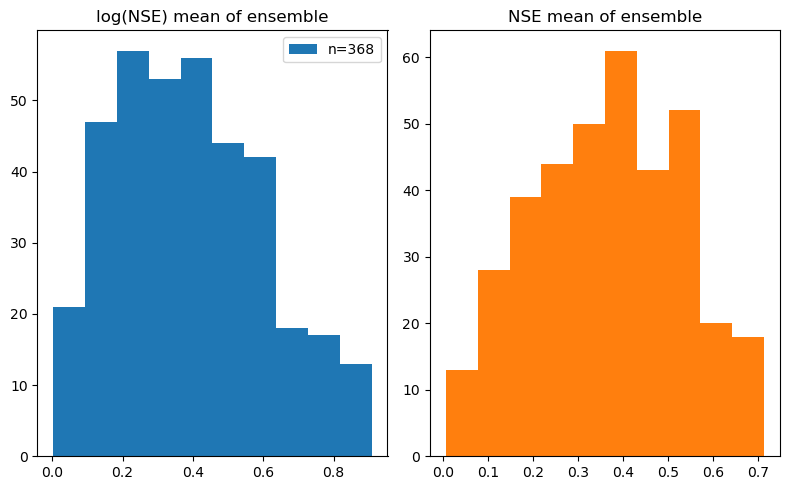

In [59]:
fig, ax = plt.subplots(1,2, figsize=(8,5))

ax[0].hist(df['NSE_mean_log'],density=False, color="C0",label=f"n={len(df)}")
ax[1].hist(df['NSE_mean'].values,density=False, color="C1")

ax[0].set_title('log(NSE) mean of ensemble')
ax[1].set_title('NSE mean of ensemble')

# ax[0].axvline(0.4, color="k")
# ax[1].axvline(0.4, color="k")

ax[0].legend()
fig.tight_layout()

fig.savefig(figure_path /'Distribution of resulting model runs')

In [25]:
df.describe(include="all")

NSE_mean  NSE_mean_log  sigma_p_Sf  sigma_w    HRU_id  dropped
count   368.000000    368.000000     368.000    368.0       368    368.0
unique  368.000000    368.000000       1.000      1.0       368      NaN
top       0.713582      0.324955       0.001      2.0  02324400      NaN
freq      1.000000      1.000000     368.000    368.0         1      NaN
mean           NaN           NaN         NaN      NaN       NaN      0.0
std            NaN           NaN         NaN      NaN       NaN      0.0
min            NaN           NaN         NaN      NaN       NaN      0.0
25%            NaN           NaN         NaN      NaN       NaN      0.0
50%            NaN           NaN         NaN      NaN       NaN      0.0
75%            NaN           NaN         NaN      NaN       NaN      0.0
max            NaN           NaN         NaN      NaN       NaN      0.0

In [26]:
df[df['NSE_mean']>0].agg(
    {

        "NSE_mean": ["min", "max", "median", "skew"],

        "NSE_mean_log": ["min", "max", "median", "mean"],

    }

)

NSE_mean  NSE_mean_log
min     0.005706      0.003060
max     0.713582      0.908254
median  0.375489      0.373513
skew   -0.053899           NaN
mean         NaN      0.389284

In [27]:
df[['sigma_p_Sf','NSE_mean_log','NSE_mean']].groupby('sigma_p_Sf').mean()

NSE_mean_log  NSE_mean
sigma_p_Sf                       
0.001          0.389284  0.364753

In [28]:
df[['sigma_w','NSE_mean_log','NSE_mean']].groupby('sigma_w').mean()

NSE_mean_log  NSE_mean
sigma_w                       
2           0.389284  0.364753

In [29]:
# summary = df[['sigma_p_Sf','sigma_w','NSE_mean','NSE_mean_log']].groupby(['sigma_p_Sf','sigma_w']).mean()
# summary = summary.sort_index(level=1)

In [30]:
# fig, ax = plt.subplots(1,1,figsize=(8,5))
# summary.plot(ax=ax,lw=0,marker='.')
# ax.set_title("Mean NSE values for 26 catchments")
# # ax.set_xlabel("Standard deviation factor of pertubation ($\epsilon_p$) \nand weight ($\sigma_w$) distribution",fontsize='large')
# ax.set_xlabel(None)
# ax.set_ylabel("NSE value for 5 years",fontsize='large')
# ax.set_xticks(range(len(summary)))
# ax.set_xticklabels(["$\epsilon_p$:%.e | $\sigma_w$:%s" % item for item in summary.index.tolist()], rotation=90);
# # https://stackoverflow.com/questions/21281322/how-to-plot-a-pandas-multiindex-dataframe-with-all-xticks

# handels, labels =  ax.get_legend_handles_labels() 
# ax.legend(handels, ["Mean NSE", "Mean Log NSE"]);

# # fig.savefig(figure_path / f'NSE_comparison_26_catchments_1d_more.png', bbox_inches="tight",dpi=100)

In [31]:
# plot_summary = summary.reset_index(level=[0,1])
# plot_summary = plot_summary.dropna()
# plot_summary = plot_summary[plot_summary['NSE_mean'] > 0]
# plot_summary = plot_summary[plot_summary['sigma_p_Sf']<0.1]

In [32]:
# best = plot_summary[(plot_summary['sigma_p_Sf' ]==0.001) & (plot_summary['sigma_w' ]==2)]
# best

In [33]:
# dummy_fig, dummy_ax = plt.subplots(1,1)
# dummy_ax.plot(0,0, marker="o",lw=0,ms=10,color="grey",zorder=-10,alpha=0.2, label="optimal value")
# handles_other, labels = dummy_ax.get_legend_handles_labels()
# plt.close(dummy_fig)

# fig, ax = plt.subplots(1,2, sharey=True,figsize=(12,5))
# fig.suptitle("Comparison of 21 variations of hyperparameter sets across 26 catchments")
# cb0 = ax[0].scatter(plot_summary['sigma_w'], plot_summary['sigma_p_Sf'], c=plot_summary['NSE_mean_log'], 
#                     cmap=cm.gist_rainbow, marker='.',s=50, edgecolors='k', linewidth=0.5)
# ax[0].set_title('mean NSE Log')
# ax[1].set_title('mean NSE')
# cb1 = ax[1].scatter(plot_summary['sigma_w'], plot_summary['sigma_p_Sf'], c=plot_summary['NSE_mean'],
#                     cmap=cm.gist_rainbow, marker='.',s=50, edgecolors='k', linewidth=0.5)
# for axs in ax:
#     axs.set_xlabel('$\sigma_w$',fontsize="large")
#     axs.plot(best['sigma_w'],best['sigma_p_Sf'], marker="o",lw=0,ms=10,color="k",zorder=-10,alpha=0.6, label="Used value")
#     axs.plot(best['sigma_w'],best['sigma_p_Sf'], marker="o",lw=0,ms=160,color="grey",zorder=-20,alpha=0.2, label="Estimated viable parameter space")
#     # axs.plot(best['sigma_w'],best['sigma_p_Sf'], marker="o",lw=0,ms=2000,color="grey",zorder=-20,alpha=0.5, label="estimated viable parameter space")
# ax[0].set_yscale('log')
# ax[0].set_ylabel('$\epsilon_p$',fontsize="large")
# handles, labels = ax[0].get_legend_handles_labels()
# ax[0].legend(handles[:1] + handles_other,labels[:2],loc=(0.3,0.125))

# plt.colorbar(cb0,label="NSE value");
# plt.colorbar(cb1,label="(log) NSE value");

# fig.tight_layout()

# # fig.savefig(figure_path / f'NSE_comparison_26_catchments_2d_more.png', bbox_inches="tight",dpi=100)

(0.0, 1.0)

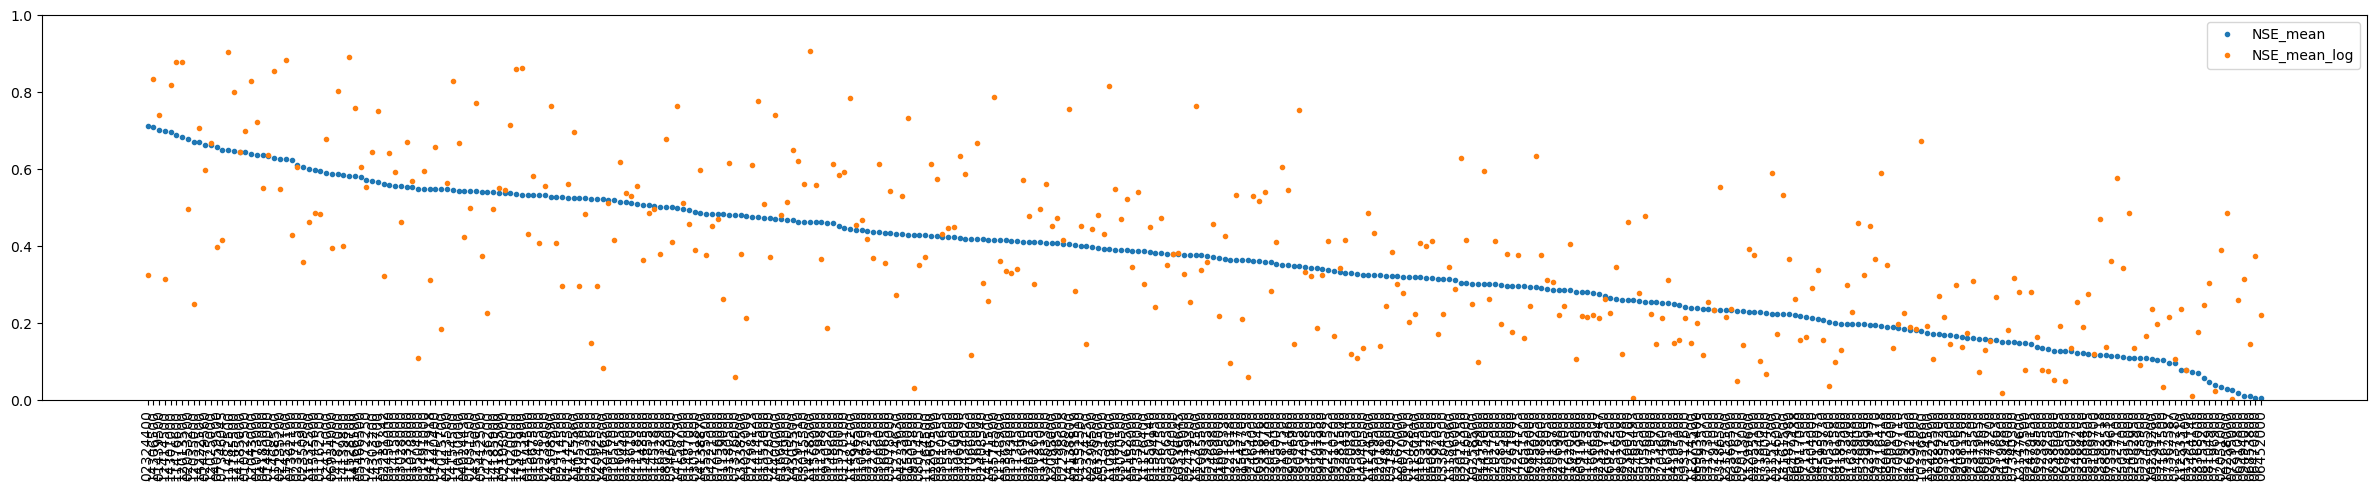

In [34]:
selection_df = df[(df['sigma_p_Sf'] != 0.1)]
fig,ax = plt.subplots(1,1,figsize=(30,5))
selection_df[['NSE_mean','NSE_mean_log']].plot(lw=0,marker='.',ax=ax)
ax.set_xticks(range(len(selection_df)))
ax.set_xticklabels(selection_df.index,rotation=90);
ax.set_ylim(0,1)

In [35]:
# selection_df = df[(df['sigma_p_Sf'] != 0.1)]
# fig,ax = plt.subplots(1,1,figsize=(50,5))
# selection_df[['NSE_mean','NSE_mean_log']].plot(lw=0,marker='.',ax=ax)
# ax.set_xticks(range(len(selection_df)))
# ax.set_xticklabels(selection_df.index,rotation=90);
# ax.set_ylim(0,1)

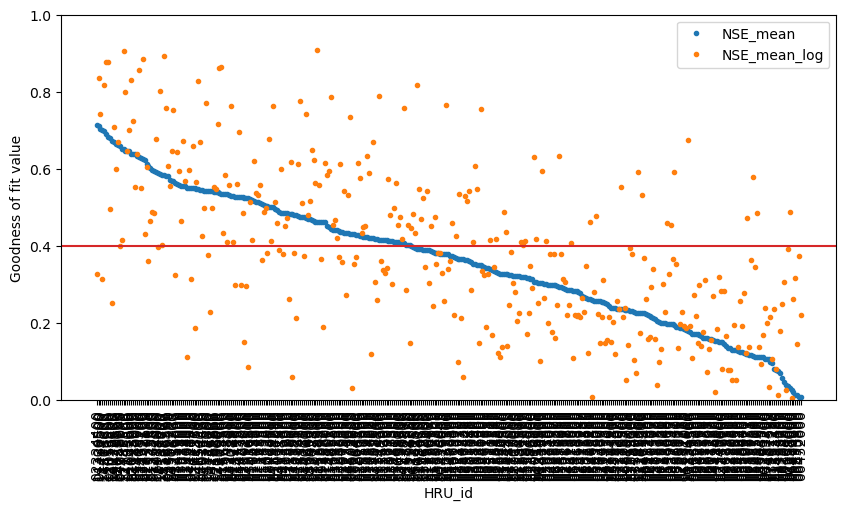

In [36]:
selection_df = df[(df['sigma_p_Sf'] == 0.001) & (df['sigma_w'] == 2)]
fig,ax = plt.subplots(1,1,figsize=(10,5))

selection_df_plot = selection_df.set_index('HRU_id')
selection_df_plot[['NSE_mean','NSE_mean_log']].plot(lw=0,marker='.',ax=ax)
ax.set_xticks(range(len(selection_df)))
ax.set_xticklabels(selection_df.index,rotation=90);
ax.set_ylim(0,1)
ax.axhline(0.4,color="C3");
ax.set_ylabel("Goodness of fit value");

In [37]:
df

NSE_mean NSE_mean_log sigma_p_Sf sigma_w    HRU_id  dropped
02324400  0.713582     0.324955      0.001       2  02324400      0.0
14306500  0.710958     0.834207      0.001       2  14306500      0.0
01439500  0.702309     0.741248      0.001       2  01439500      0.0
12414500   0.70034     0.314298      0.001       2  12414500      0.0
14301000  0.697508     0.817938      0.001       2  14301000      0.0
...            ...          ...        ...     ...       ...      ...
06910800  0.019385     0.260864      0.001       2  06910800      0.0
09494000  0.011976     0.315212      0.001       2  09494000      0.0
06853800  0.010923     0.145232      0.001       2  06853800      0.0
06470800  0.006153     0.373686      0.001       2  06470800      0.0
06452000  0.005706     0.220703      0.001       2  06452000      0.0

[368 rows x 6 columns]

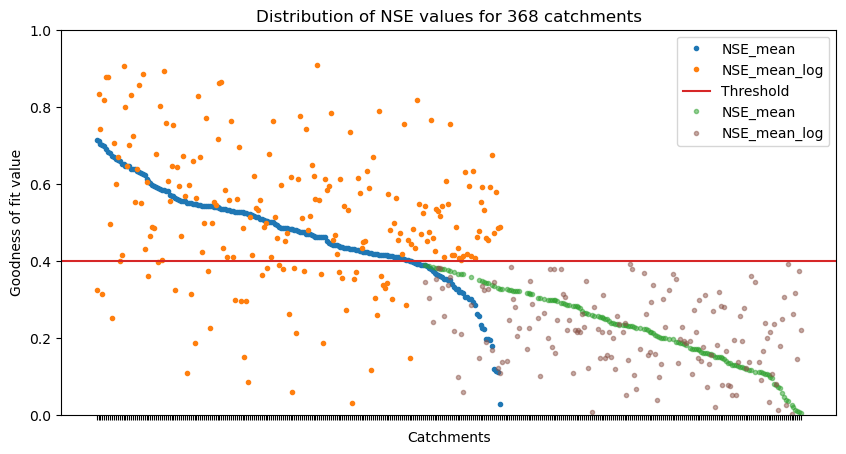

In [38]:

selection_df = df[(df['sigma_p_Sf'] == 0.001) & (df['sigma_w'] == 2)].copy()
selection_df_plot = selection_df.set_index('HRU_id')
selection_df_plot['dropped'] = selection_df_plot.apply(lambda x: np.nan if x.NSE_mean < 0.4 and x.NSE_mean_log < 0.4 else 0, axis=1)

selection_df_dopped = df[(df['sigma_p_Sf'] == 0.001) & (df['sigma_w'] == 2)].copy()
selection_df_dopped = selection_df_dopped.set_index('HRU_id')
selection_df_dopped['NSE_mean'] = selection_df_dopped.apply(lambda x: x.NSE_mean if x.NSE_mean < 0.4 and x.NSE_mean_log < 0.4 else np.nan, axis=1)
selection_df_dopped['NSE_mean_log'] = selection_df_dopped.apply(lambda x: x.NSE_mean_log if x.NSE_mean < 0.4 and x.NSE_mean_log < 0.4 else np.nan, axis=1)

selection_df_plot = selection_df_plot.dropna()
# selection_df_dopped = selection_df_dopped.dropna()


fig,ax = plt.subplots(1,1,figsize=(10,5))
selection_df_plot[['NSE_mean','NSE_mean_log']].plot(lw=0,marker='.',ax=ax)
ax.axhline(0.4,color="C3",label="Threshold")

selection_df_dopped[['NSE_mean']].plot(lw=0,marker='.',ax=ax,color="C2",alpha=0.5)
selection_df_dopped[['NSE_mean_log']].plot(lw=0,marker='.',ax=ax,color="C5",alpha=0.5)
ax.set_xticks(range(len(selection_df)))
ax.set_xticklabels([None]*len(selection_df),rotation=90,fontsize='x-small');
ax.set_ylim(0,1)
ax.set_ylabel("Goodness of fit value")
ax.set_xlabel("Catchments")


handles, labels = ax.get_legend_handles_labels()
ax.legend()
title = f"Distribution of NSE values for {len(selection_df)} catchments"
ax.set_title(title);

fig.savefig(figure_path / (title + 'png'), bbox_inches="tight",dpi=400)

In [39]:
output = False
if output:
    selection_df_plot.to_feather(analysis_path / "selected_catchments.feather")
    df.to_feather(analysis_path / "catchments_NSE_gt_0.feather")

In [40]:
len(selection_df_plot)

211

In [41]:
# paths_analysed_ds = []
# for key in selected_df.index:
#     paths_analysed_ds.append(dict_files[key])

In [42]:
# paths_analysed_ds

#### best 25

In [43]:
best_25 = df.sort_values('NSE_mean_log',ascending=False).head(25)
best_25

NSE_mean NSE_mean_log sigma_p_Sf sigma_w    HRU_id  dropped
11478500  0.462452     0.908254      0.001       2  11478500      0.0
11482500   0.65046      0.90448      0.001       2  11482500      0.0
11528700  0.582881     0.891965      0.001       2  11528700      0.0
11451100  0.626027     0.885029      0.001       2  11451100      0.0
11476600  0.689447      0.87749      0.001       2  11476600      0.0
12013500  0.682565     0.877392      0.001       2  12013500      0.0
11473900  0.534062     0.863055      0.001       2  11473900      0.0
14309500  0.536616     0.861655      0.001       2  14309500      0.0
11468500   0.63009     0.856555      0.001       2  11468500      0.0
14306500  0.710958     0.834207      0.001       2  14306500      0.0
12043000  0.638458     0.829683      0.001       2  12043000      0.0
14154500  0.545971     0.828727      0.001       2  14154500      0.0
14301000  0.697508     0.817938      0.001       2  14301000      0.0
11098000  0.391654     0.817278      0.001       2  11098000      0.0
14187000   0.58645     0.802297      0.001       2  14187000      0.0
12145500  0.646201     0.800107      0.001       2  12145500      0.0
03574500   0.41566     0.788884      0.001       2  03574500      0.0
11481200  0.443779     0.784864      0.001       2  11481200      0.0
01414500  0.475143     0.776173      0.001       2  01414500      0.0
14325000  0.542838     0.770901      0.001       2  14325000      0.0
11237500  0.377275     0.764674      0.001       2  11237500      0.0
14158790  0.500024     0.763501      0.001       2  14158790      0.0
14308990   0.52914     0.763202      0.001       2  14308990      0.0
14166500   0.58151     0.758389      0.001       2  14166500      0.0
14138800  0.405459      0.75622      0.001       2  14138800      0.0

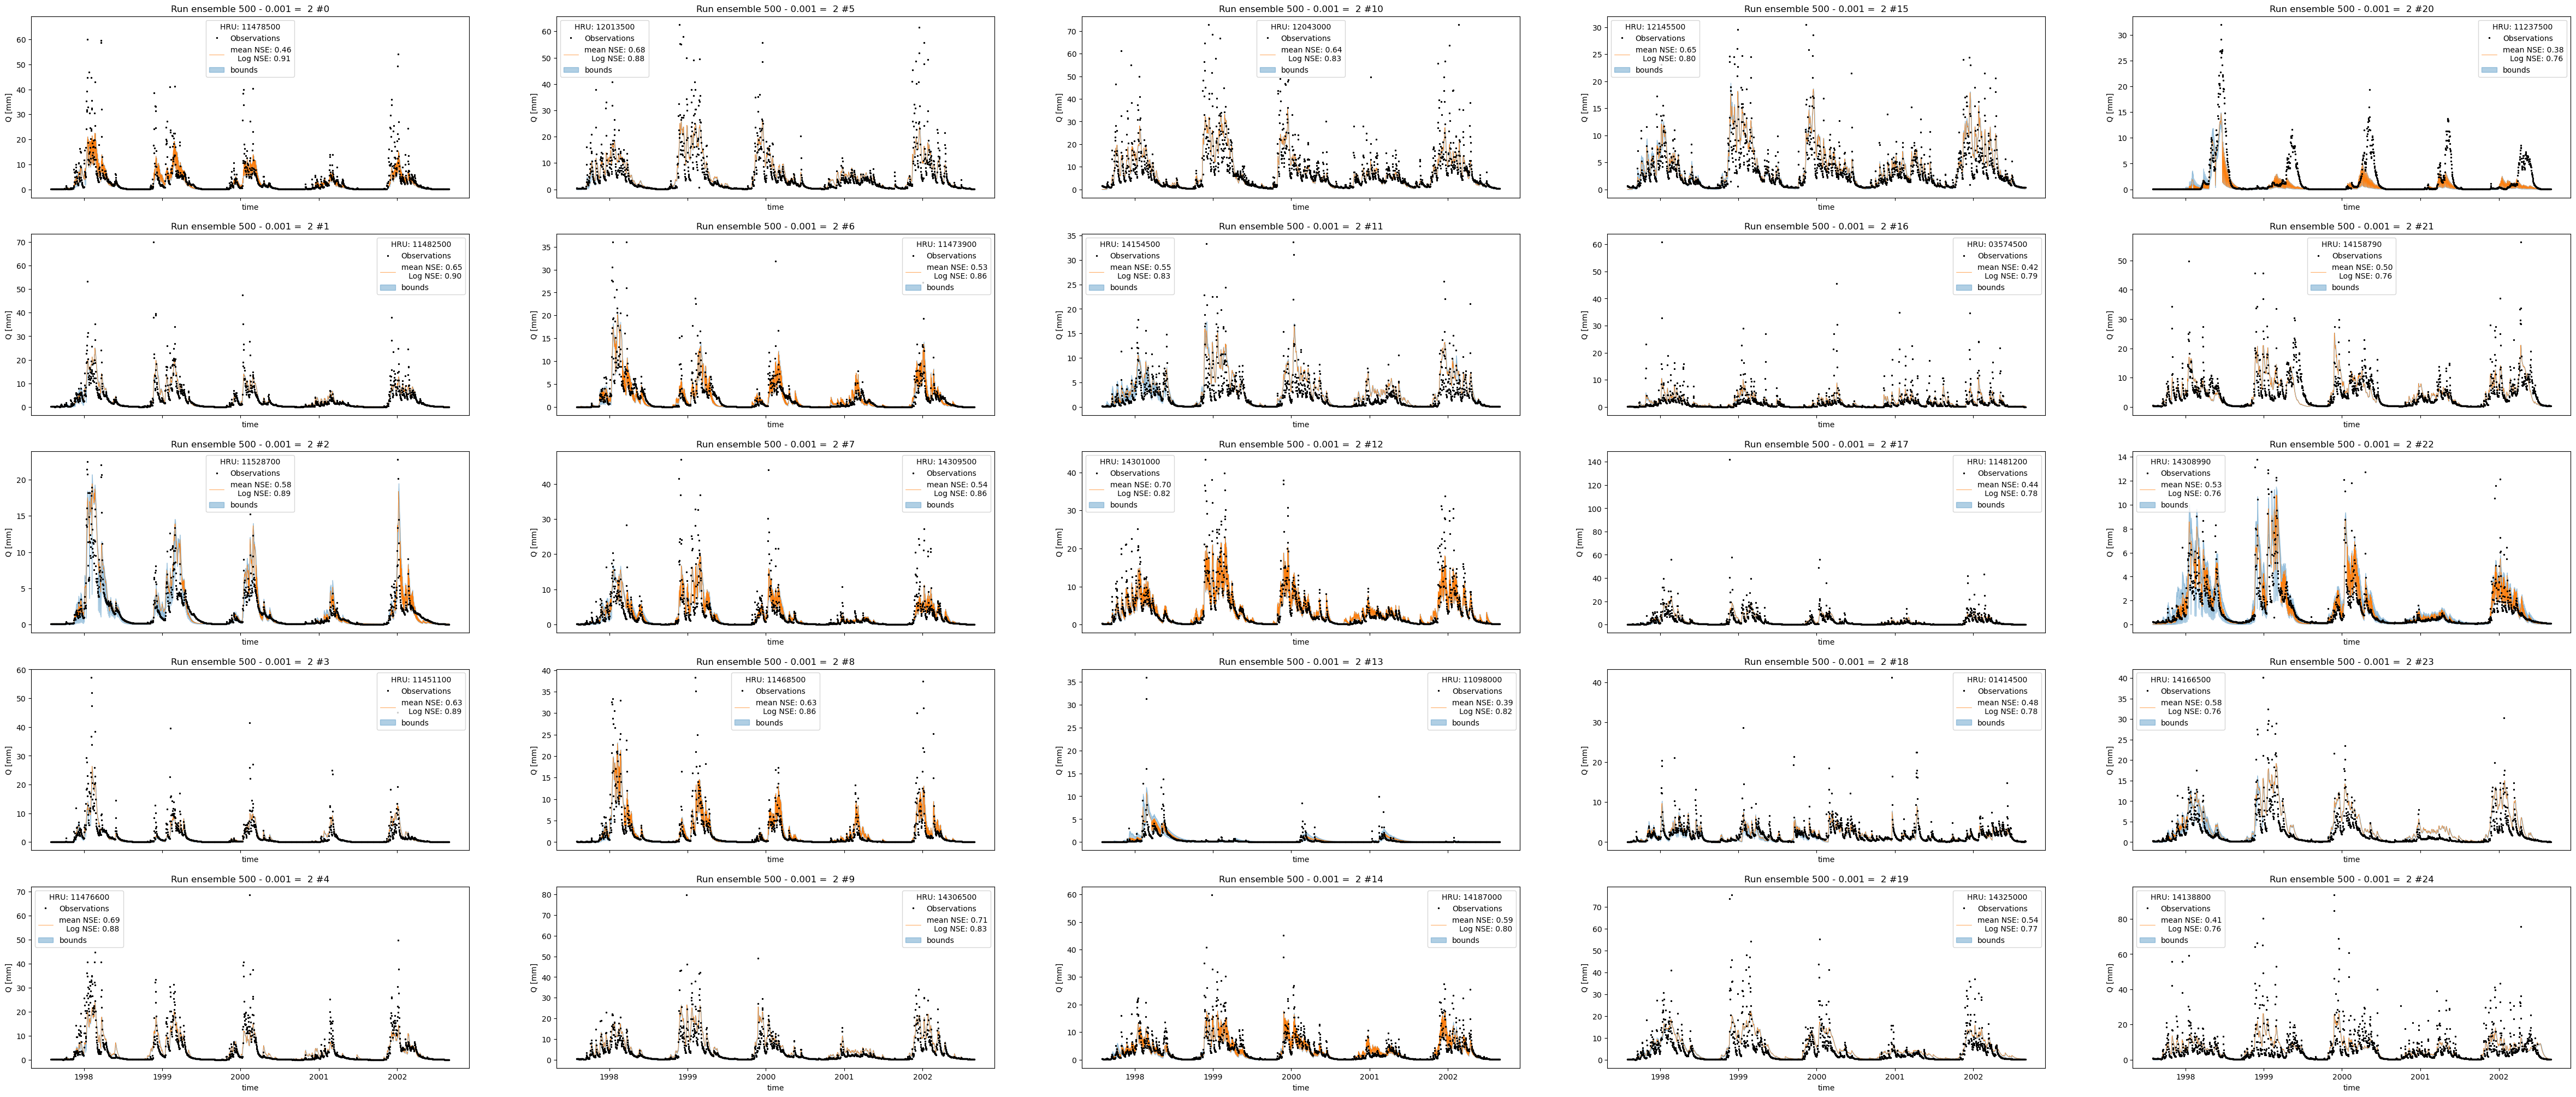

In [44]:
y1, x1   = 5,5
fig, axs_2d = plt.subplots(y1,x1,figsize=(12*x1,5*y1), sharex=True)
j = 0
k = 0
for i in range(0,x1*y1):
    if k >= y1: 
        j += 1
        k = 0
    ax = axs_2d[k, j]
    k += 1

    if i >= len(lst_ds):
        ax.axis('off')
    else:
        ds_combined = lst_ds[sorted_iter.index(best_25.index[i])]
        ax = plot_hydrograph(ds_combined, ax)
        ax.set_title(f'Run ensemble {ds_combined.attrs["n_particles"]} - {ds_combined.attrs["sigma_p_Sf"]} =  {ds_combined.attrs["sigma_w"]} #{i}')
        # if k == 1:
        ax.legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
        # else:
            # ax.legend()

# fig.savefig(figure_path / f'vary_catchments.png', bbox_inches="tight",dpi=400)

#### Best 25 w=2,s=1e-3

In [45]:
df_best_2_1e3 = df[df['sigma_w'] == 2]
df_best_2_1e3 = df_best_2_1e3[df_best_2_1e3['sigma_p_Sf']==0.001]
df_best_2_1e3

NSE_mean NSE_mean_log sigma_p_Sf sigma_w    HRU_id  dropped
02324400  0.713582     0.324955      0.001       2  02324400      0.0
14306500  0.710958     0.834207      0.001       2  14306500      0.0
01439500  0.702309     0.741248      0.001       2  01439500      0.0
12414500   0.70034     0.314298      0.001       2  12414500      0.0
14301000  0.697508     0.817938      0.001       2  14301000      0.0
...            ...          ...        ...     ...       ...      ...
06910800  0.019385     0.260864      0.001       2  06910800      0.0
09494000  0.011976     0.315212      0.001       2  09494000      0.0
06853800  0.010923     0.145232      0.001       2  06853800      0.0
06470800  0.006153     0.373686      0.001       2  06470800      0.0
06452000  0.005706     0.220703      0.001       2  06452000      0.0

[368 rows x 6 columns]

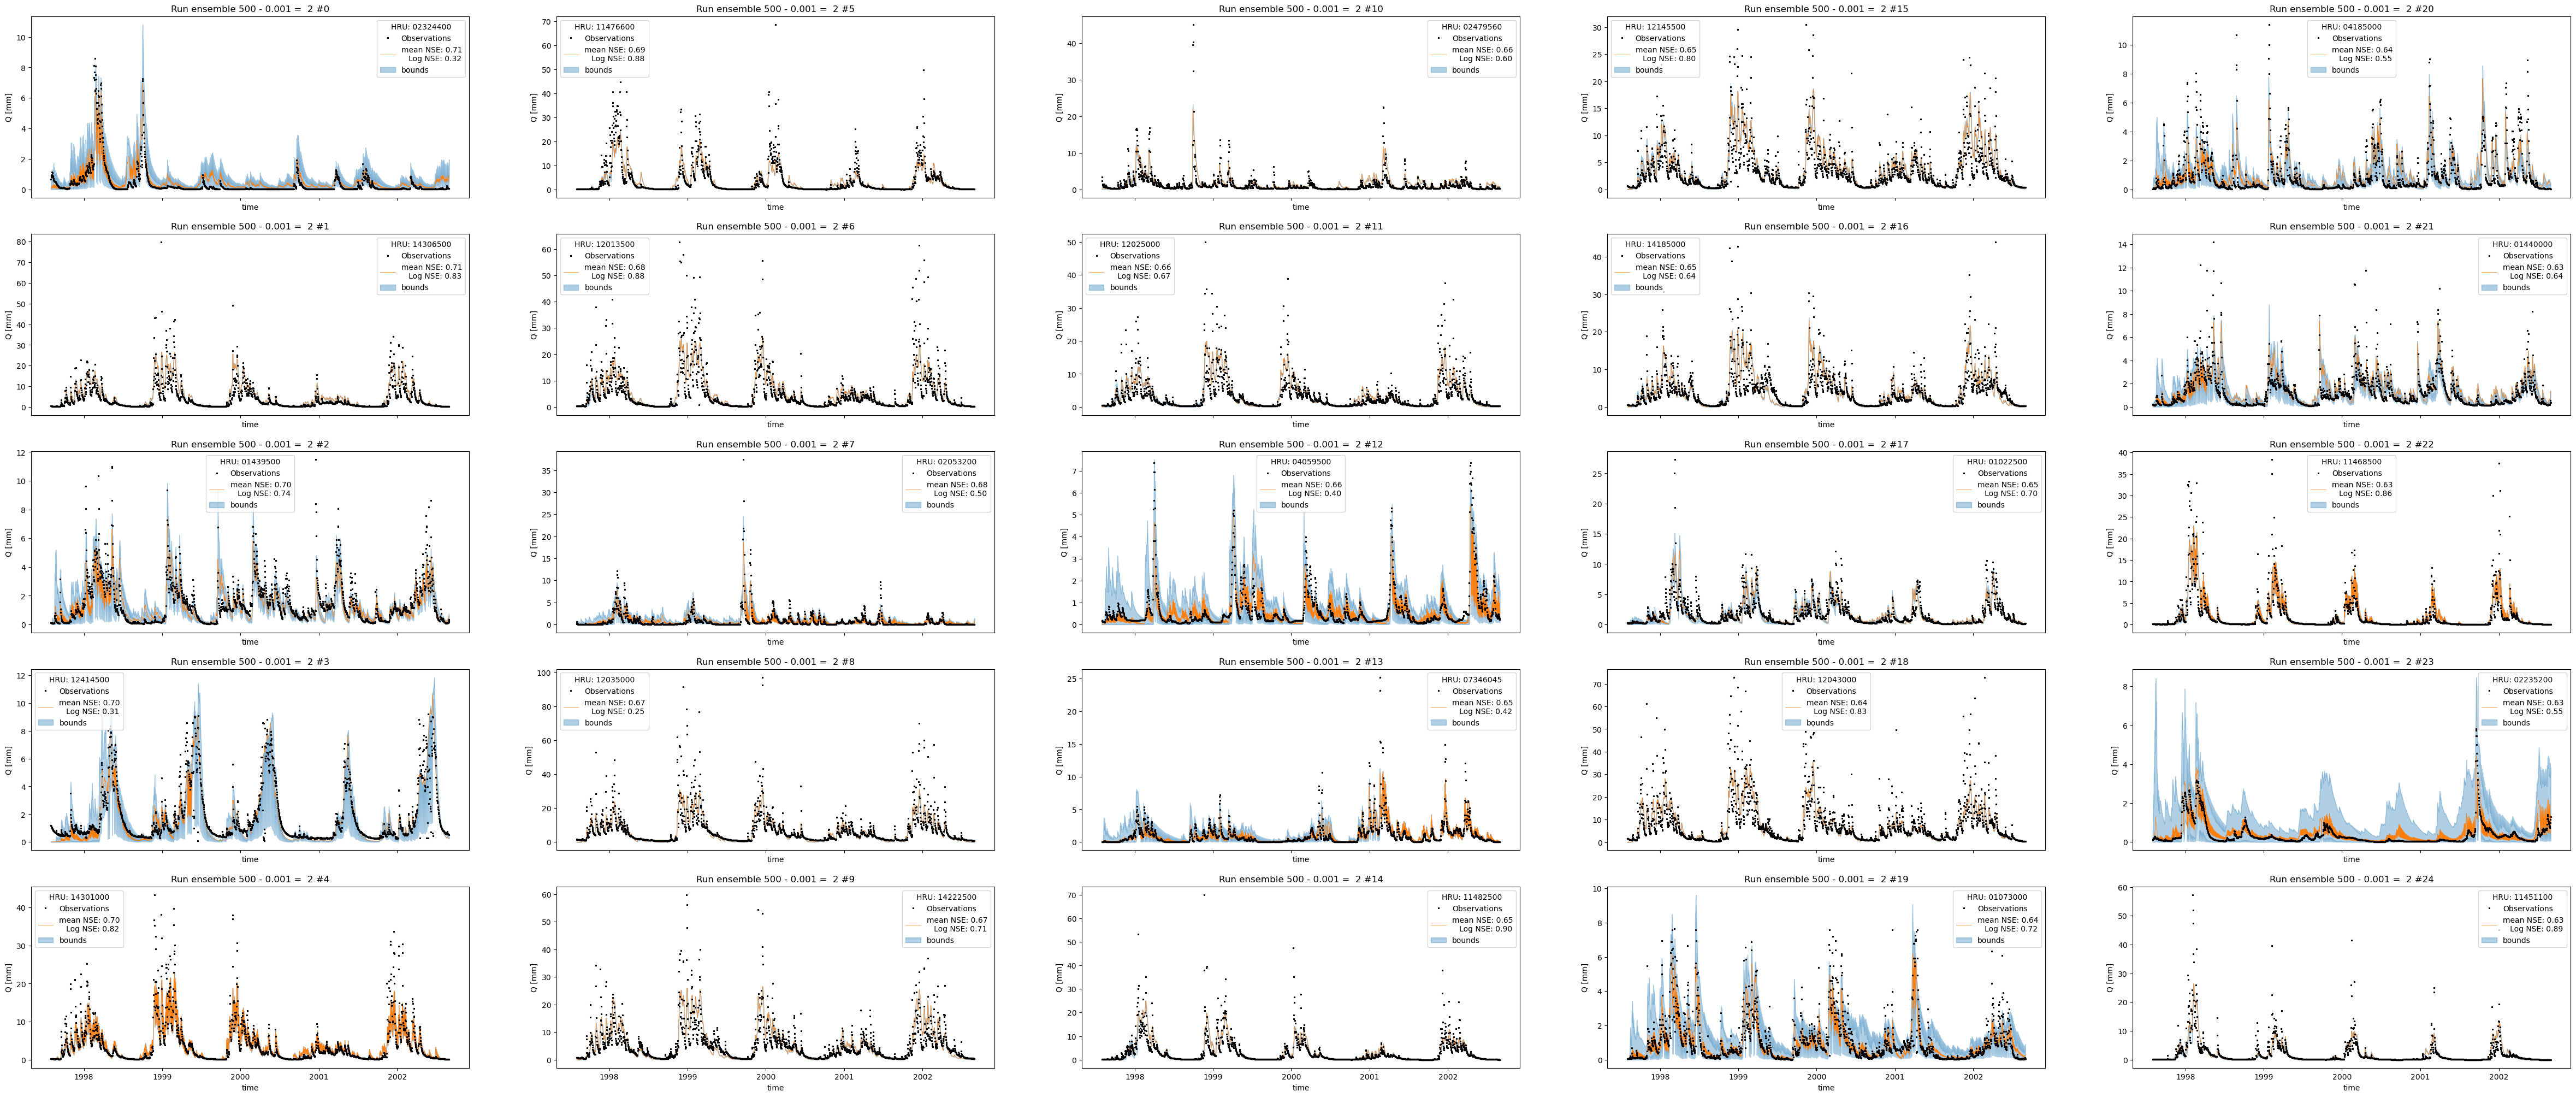

In [46]:
y1, x1   = 5,5
fig, axs_2d = plt.subplots(y1,x1,figsize=(12*x1,5*y1), sharex=True)
j = 0
k = 0
for i in range(0,x1*y1):
    if k >= y1: 
        j += 1
        k = 0
    ax = axs_2d[k, j]
    k += 1

    if i >= len(lst_ds):
        ax.axis('off')
    else:
        ds_combined = lst_ds[sorted_iter.index(df_best_2_1e3.index[i])]
        ax = plot_hydrograph(ds_combined, ax)
        ax.set_title(f'Run ensemble {ds_combined.attrs["n_particles"]} - {ds_combined.attrs["sigma_p_Sf"]} =  {ds_combined.attrs["sigma_w"]} #{i}')
        # if k == 1:
        ax.legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
        # else:
            # ax.legend()

# fig.savefig(figure_path / f'vary_catchments.png', bbox_inches="tight",dpi=400)

# Good example:

In [47]:
# i = sorted_iter.index('01439500')
# i = sorted_iter.index('04045500')
i = sorted_iter.index('11478500')

ds_combined = lst_ds[i]
ds_combined

<xarray.Dataset> Size: 728kB
Dimensions:       (summary_stat: 3, time: 1857)
Coordinates:
  * summary_stat  (summary_stat) <U4 48B 'min' 'max' 'mean'
  * time          (time) datetime64[ns] 15kB 1997-08-01 ... 2002-08-31
Data variables: (12/18)
    Imax          (summary_stat, time) float64 45kB ...
    Ce            (summary_stat, time) float64 45kB ...
    Sumax         (summary_stat, time) float64 45kB ...
    Beta          (summary_stat, time) float64 45kB ...
    Pmax          (summary_stat, time) float64 45kB ...
    Tlag          (summary_stat, time) float64 45kB ...
    ...            ...
    Ss            (summary_stat, time) float64 45kB ...
    Sp            (summary_stat, time) float64 45kB ...
    Q             (summary_stat, time) float64 45kB ...
    Q_obs         (time) float64 15kB 0.08088 0.08088 ... 0.02128 0.02001
    Neff          (time) float64 15kB ...
    n_resample    (time) float64 15kB ...
Attributes: (12/13)
    title:              HBV storage & parameter terms data over time for 500 ...
    history:            Storage term results from ewatercycle_HBV.model
    sigma_pp:           0
    sigma_ps:           0
    sigma_w:            2
    sigma_p_Sf:         0.001
    ...                 ...
    n_particles:        500
    HRU_id:             11478500
    p_min_initial:      [3.27131979e+00 6.11283983e-01 3.29153286e+02 2.35486...
    p_max_initial:      [4.20799804e+00 7.05586592e-01 4.04169344e+02 2.75077...
    s_max_initial:      [  2.32618665 258.31217414  96.57573298  32.46911099 ...
    s_min_initial:      [  1.45484916 218.49676975  71.77396027  29.90155209 ...

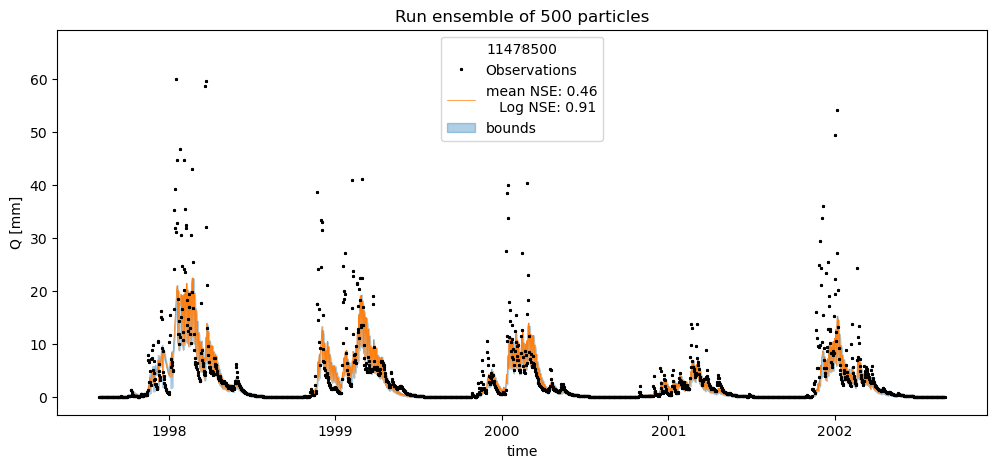

In [48]:
fig, ax = plt.subplots(1,1, figsize=(12,5),sharex=True)
ax = plot_hydrograph(ds_combined, ax)
ax.legend(title=ds_combined.attrs['HRU_id'])
current_time = str(datetime.now())[:-10].replace(":","_")
# fig.savefig(figure_path / f"Ensemble run for {ds_combined.attrs['HRU_id']}_{ds_combined.attrs['n_particles']}_{current_time}.png",bbox_inches="tight", dpi=600)

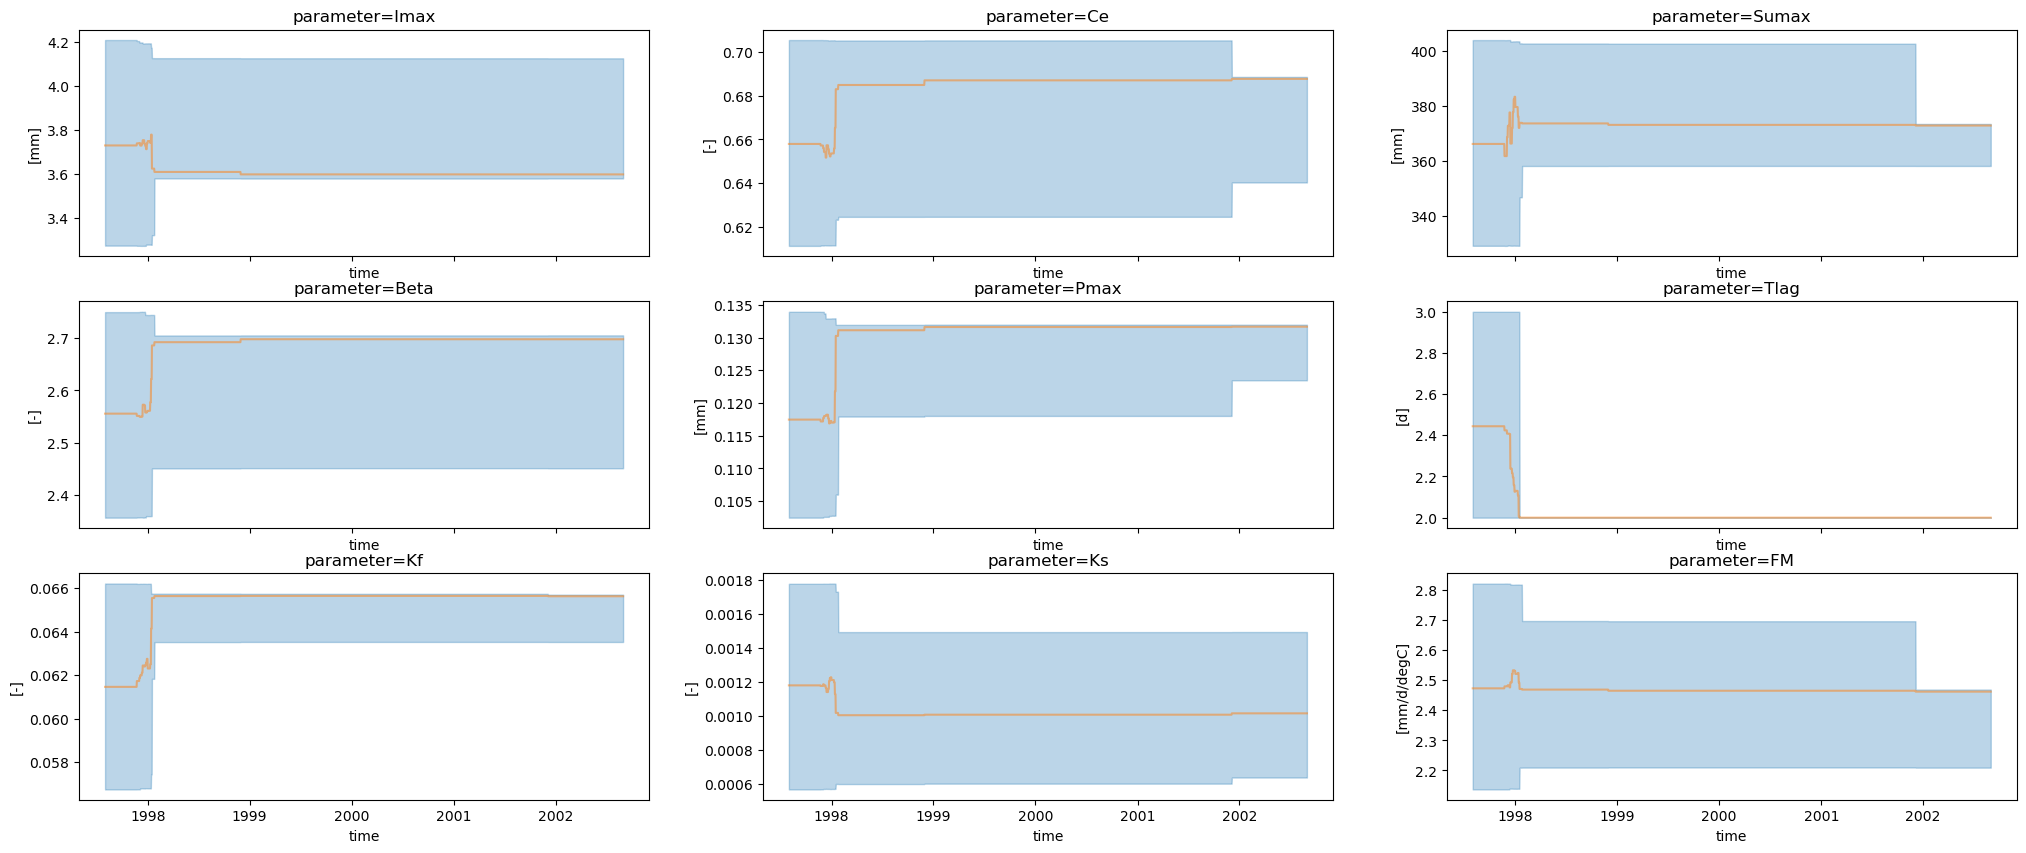

In [49]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
    ax.fill_between(ds_combined.time, 
                     ds_combined[parameter].sel(summary_stat="min").values,
                     ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

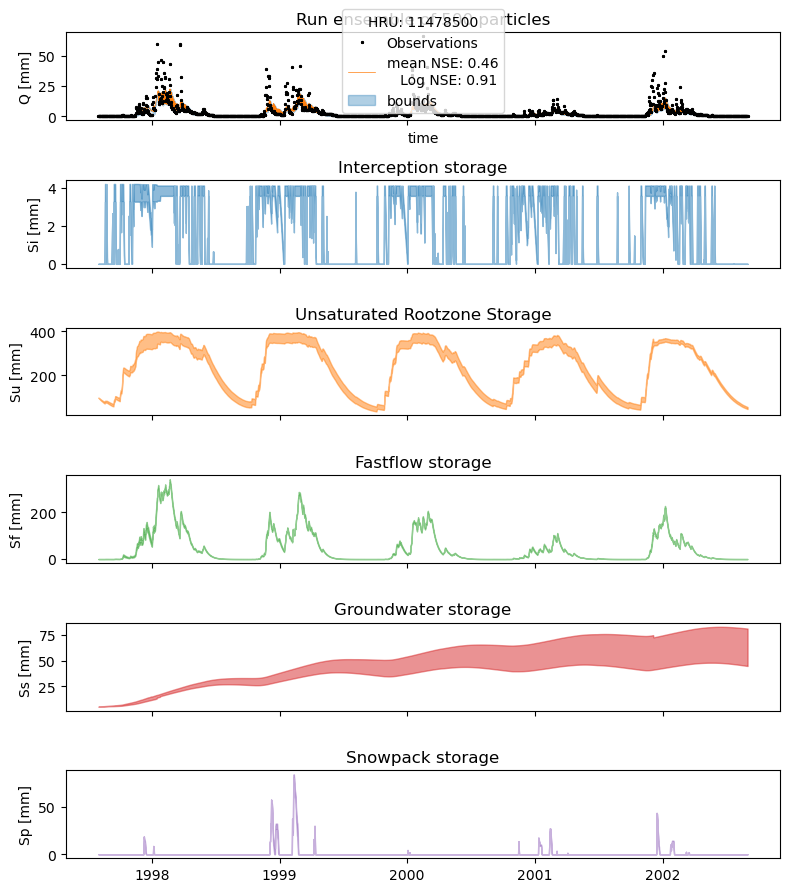

In [50]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

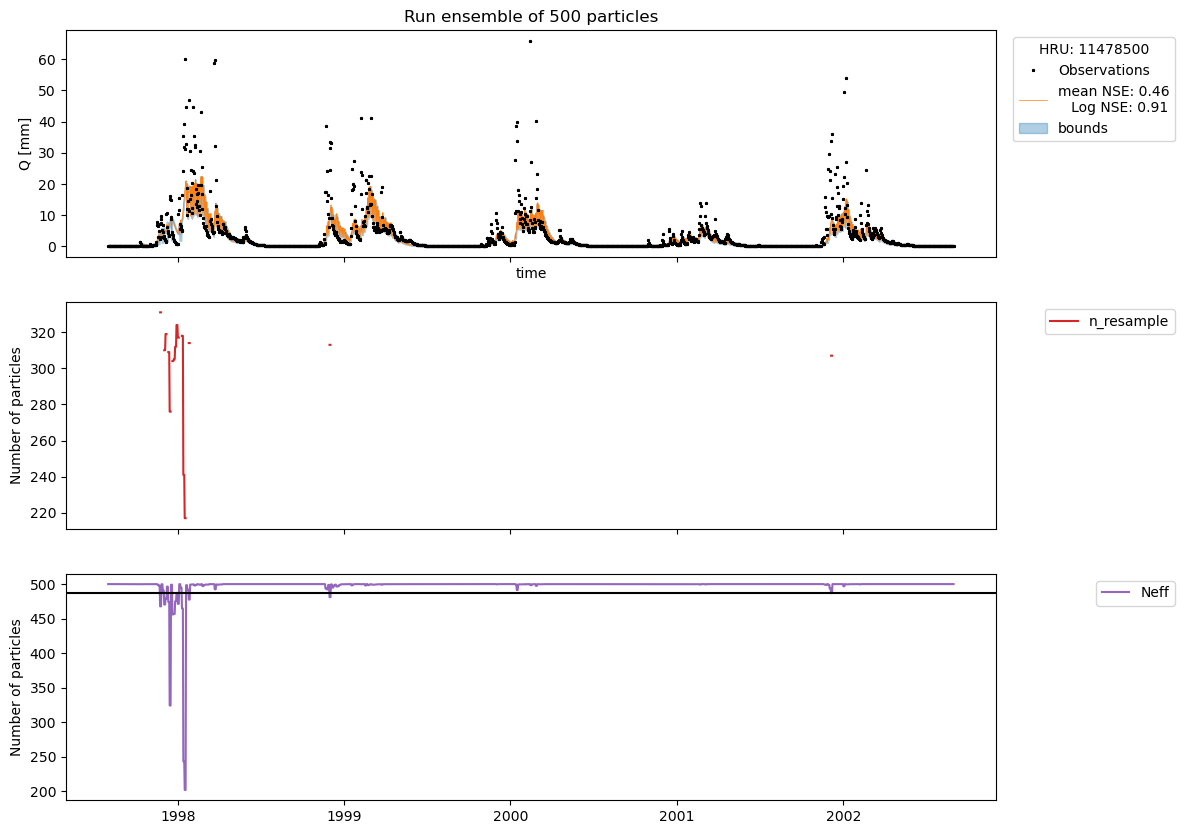

In [51]:
fig, ax = plt.subplots(3,1, figsize=(12,10),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.2,1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend(bbox_to_anchor=(1.2,1))
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

# another

In [52]:
i = sorted_iter.index( '01022500')
ds_combined = lst_ds[i]
ds_combined

<xarray.Dataset> Size: 728kB
Dimensions:       (summary_stat: 3, time: 1857)
Coordinates:
  * summary_stat  (summary_stat) <U4 48B 'min' 'max' 'mean'
  * time          (time) datetime64[ns] 15kB 1997-08-01 ... 2002-08-31
Data variables: (12/18)
    Imax          (summary_stat, time) float64 45kB ...
    Ce            (summary_stat, time) float64 45kB ...
    Sumax         (summary_stat, time) float64 45kB ...
    Beta          (summary_stat, time) float64 45kB ...
    Pmax          (summary_stat, time) float64 45kB ...
    Tlag          (summary_stat, time) float64 45kB ...
    ...            ...
    Ss            (summary_stat, time) float64 45kB ...
    Sp            (summary_stat, time) float64 45kB ...
    Q             (summary_stat, time) float64 45kB ...
    Q_obs         (time) float64 15kB 0.254 0.2456 0.2498 ... 0.154 0.1499
    Neff          (time) float64 15kB ...
    n_resample    (time) float64 15kB ...
Attributes: (12/13)
    title:              HBV storage & parameter terms data over time for 500 ...
    history:            Storage term results from ewatercycle_HBV.model
    sigma_pp:           0
    sigma_ps:           0
    sigma_w:            2
    sigma_p_Sf:         0.001
    ...                 ...
    n_particles:        500
    HRU_id:             01022500
    p_min_initial:      [1.12182327e+00 3.22232898e-01 1.13079965e+02 1.37713...
    p_max_initial:      [3.20383033e+00 6.15753470e-01 3.05794566e+02 3.21596...
    s_max_initial:      [  2.55532786 167.43273213  42.05499716  32.14507687 ...
    s_min_initial:      [ 0.73914092 62.34886481 17.85686147 12.90167866 39.0...

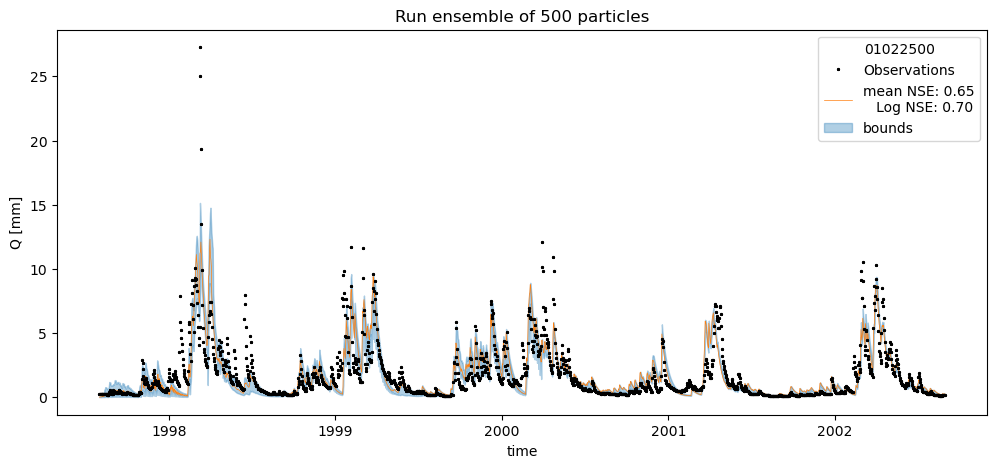

In [53]:
fig, ax = plt.subplots(1,1, figsize=(12,5),sharex=True)
ax = plot_hydrograph(ds_combined, ax)
ax.legend(title=ds_combined.attrs['HRU_id'])
current_time = str(datetime.now())[:-10].replace(":","_")
# fig.savefig(figure_path / f"Ensemble run for {ds_combined.attrs['HRU_id']}_{ds_combined.attrs['n_particles']}_{current_time}.png",bbox_inches="tight", dpi=600)

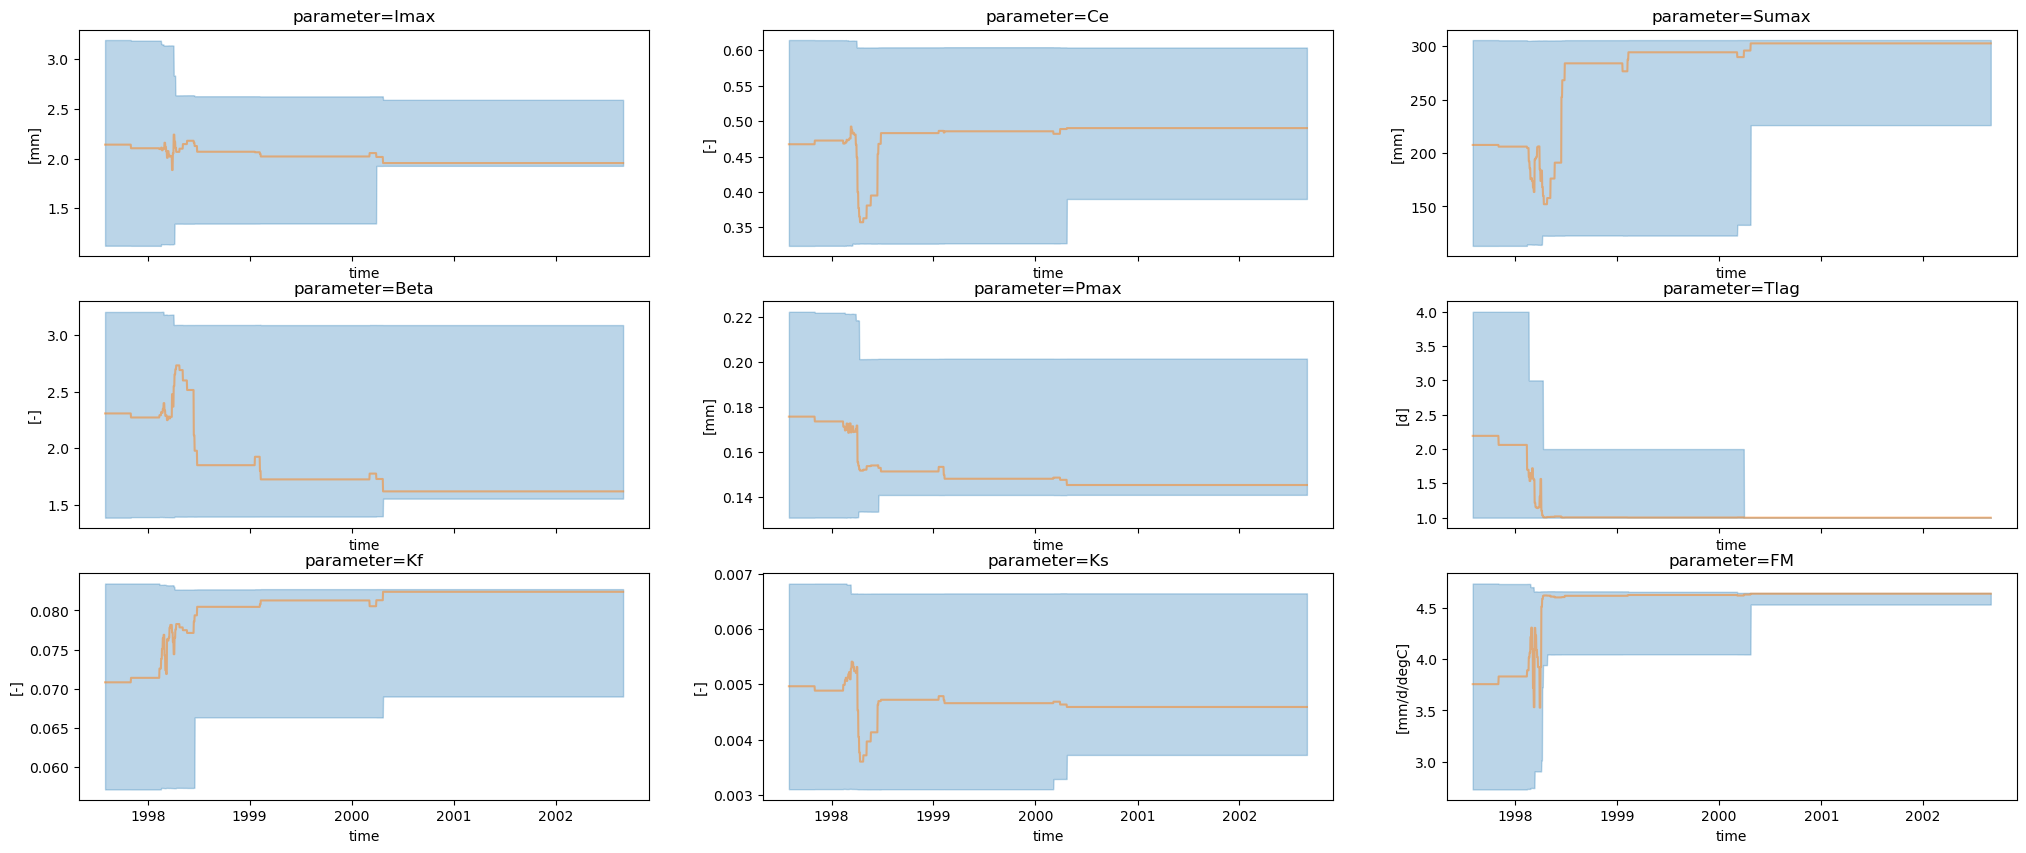

In [54]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    
    ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
    ax.fill_between(ds_combined.time, 
                     ds_combined[parameter].sel(summary_stat="min").values,
                     ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

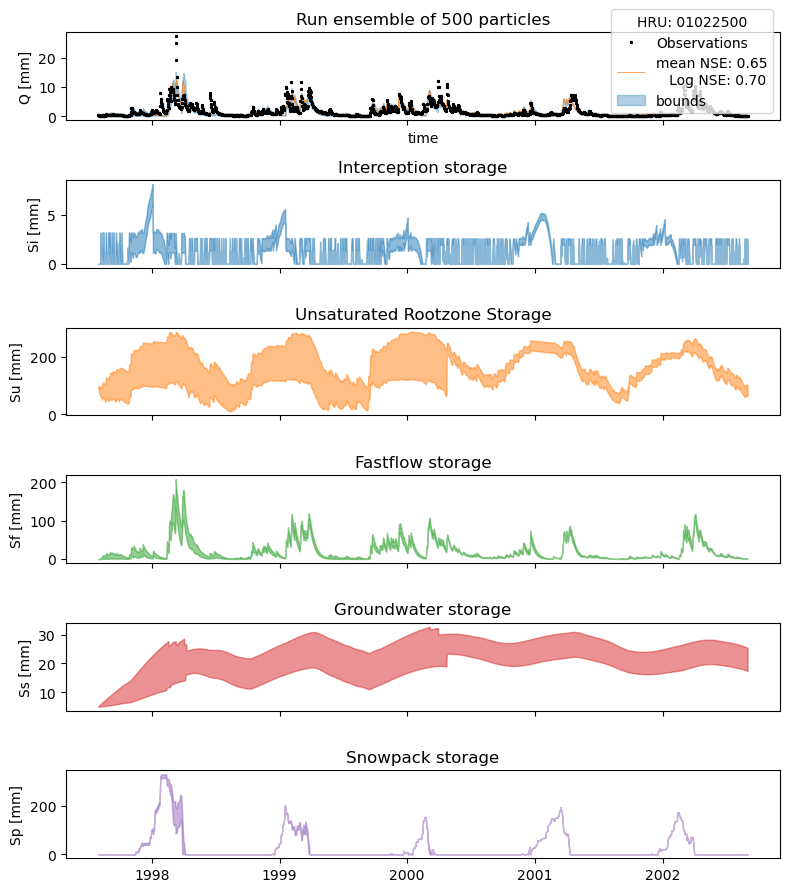

In [54]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

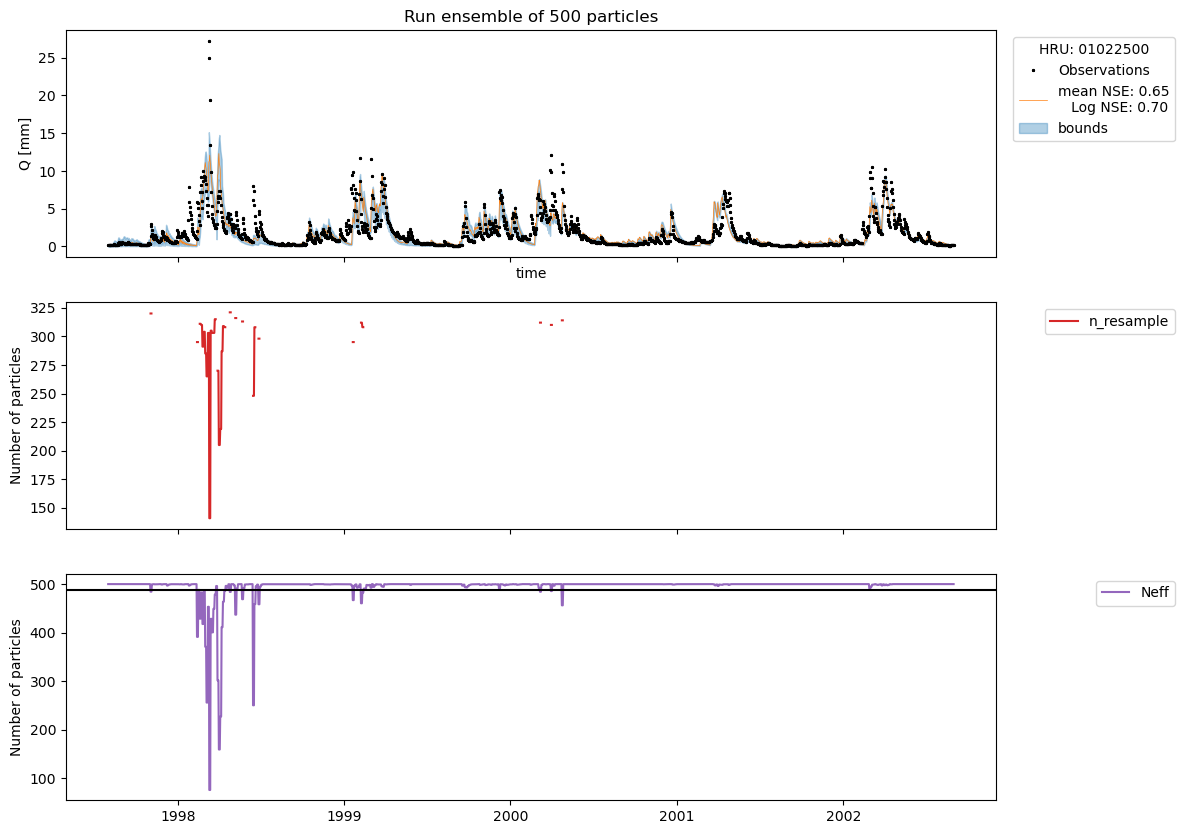

In [55]:
fig, ax = plt.subplots(3,1, figsize=(12,10),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.2,1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend(bbox_to_anchor=(1.2,1))
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

In [56]:
param_names

['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks', 'FM']

In [57]:
stor_names

['Si', 'Su', 'Sf', 'Ss', 'Sp']

In [58]:
param_arr = np.zeros((len(lst_ds),2,len(param_names)))
stor_arr = np.zeros((len(lst_ds),2,len(stor_names)))
         
for index, ds_combined in enumerate(lst_ds):
    param_arr[index,0] = ds_combined.attrs['p_min_initial'] 
    param_arr[index,1] = ds_combined.attrs['p_max_initial']
    stor_arr[index,0] = ds_combined.attrs['s_min_initial'] 
    stor_arr[index,1] = ds_combined.attrs['s_max_initial']

In [59]:
param_names_no_su = param_names[:2] + param_names[3:]
param_names_no_su

['Imax', 'Ce', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks', 'FM']

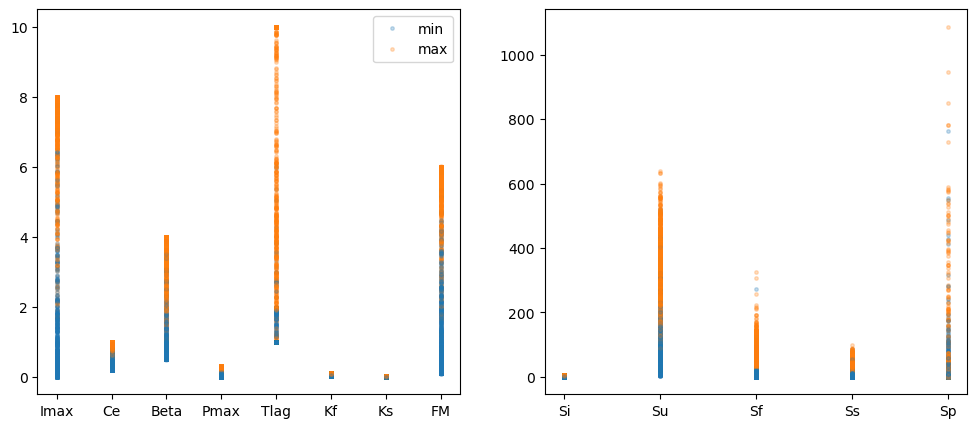

In [60]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
common_kwargs  = {"marker":'o',
                  "lw":0, 
                  "ms": 2.5,
                  "alpha": 0.25,
                 }
for arr in param_arr:
    arr_no_su_0 = list(arr[0][:2]) + list(arr[0][3:])
    ax[0].plot(param_names_no_su, arr_no_su_0, color="C0",label="min",**common_kwargs)
    arr_no_su_1 = list(arr[1][:2]) + list(arr[1][3:])
    ax[0].plot(param_names_no_su, arr_no_su_1, color="C1",label="max",**common_kwargs)

handels, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handels[:2], labels[:2])
for arr in stor_arr:
    ax[1].plot(stor_names, arr[0], color="C0",**common_kwargs)
    ax[1].plot(stor_names, arr[1], color="C1",**common_kwargs)

In [61]:
param_arr.shape

(661, 2, 9)

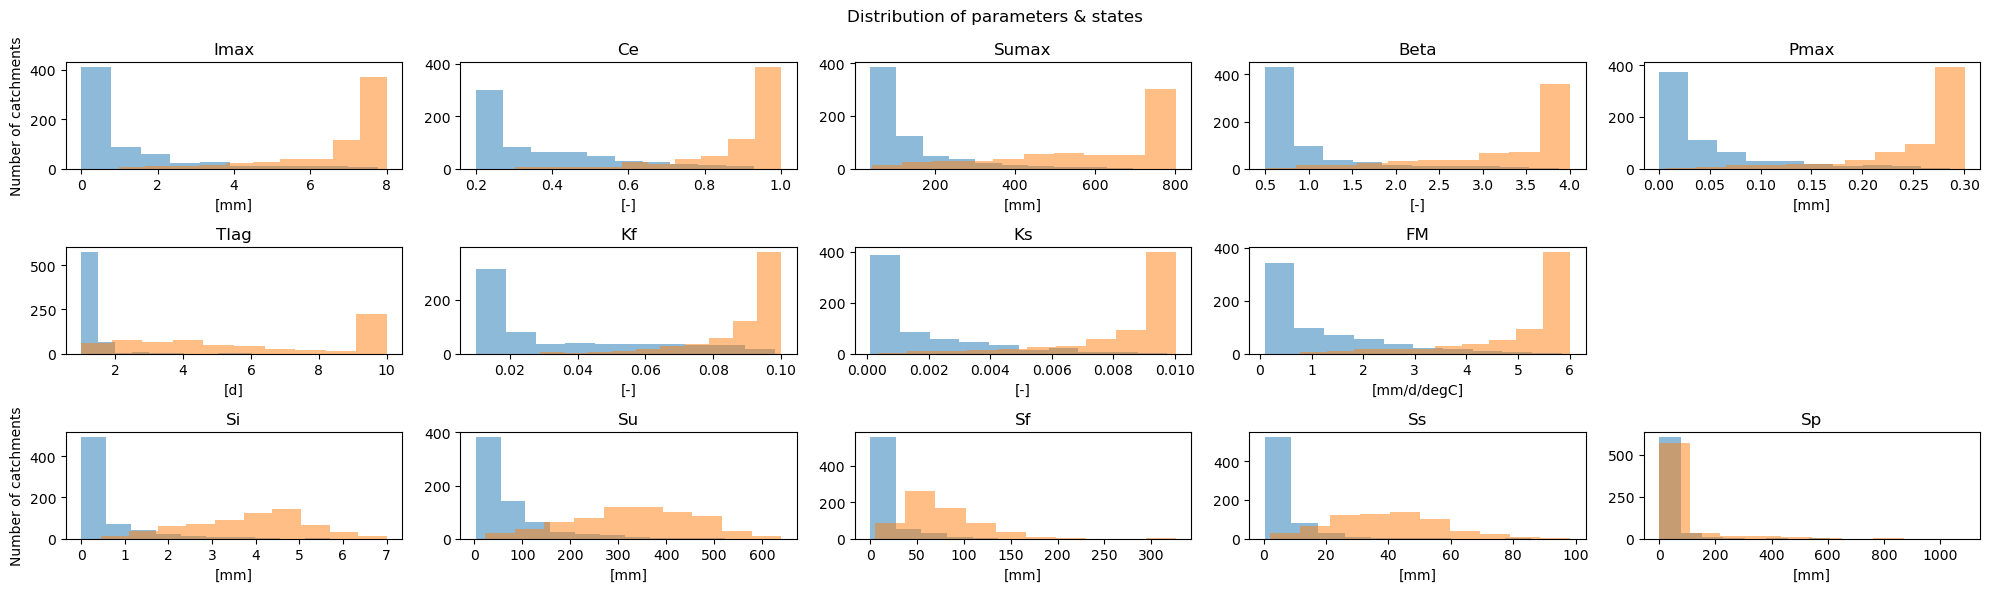

In [62]:
fig, ax = plt.subplots(3,5, figsize=(20,6), sharey=False, sharex=False)
ax = ax.flatten()
names = param_names + [None] + stor_names
for i, param_name in enumerate(names): 
    if param_name is None:
        ax[i].axis('off');
    else:
        if i < 9:
            n = i
            arr = param_arr
        else:
            n = i-10
            arr = stor_arr
        ax[i].hist(arr[:,0,n],density=False,facecolor=f"C0",alpha=0.5, label="min")
        ax[i].hist(arr[:,1,n],density=False,facecolor=f"C1",alpha=0.5, label="max")
        ax[i].set_title(param_name)
        ax[i].set_xlabel(f'[{units[param_name]}]' )
        if i in [0, 10]:
            ax[i].set_ylabel('Number of catchments')
        

fig.suptitle(f"Distribution of parameters & states");
fig.tight_layout();
fig.savefig(figure_path / ("distribution_of_initial_parameters_and_states" + '_storages.png'), bbox_inches="tight",dpi=200)